# Compare the performance of several pre-processing pipelines in terms of motion correction as measured by the root mean square of the temporal derivative of the post-processed fMRI signal (DVARS)

### Spurious but systematic correlations in functional connectivity MRI networks arise from subject motion - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3254728/

### Comparing resting state fMRI de-noising approaches using multi- and single-echo acquisitions (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0173289)  
### An evaluation of the efficacy, reliability, and sensitivity of motion correction strategies for resting-state functional MRI (https://www.sciencedirect.com/science/article/pii/S1053811917310972)

In [1]:
import glob
import os
import sys

import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from scipy import stats
from scipy.stats import wilcoxon

from statsmodels.stats.multitest import multipletests
import statannot
from statannot import add_stat_annotation

import itertools

In [2]:
# First, check if the ASC and TD groups differ significantly in terms of age, IQ 
# and in-scanner movement (i.e. framewise displacement - FD)
# Participant list : 
# M005B, M007A, M008A, M010A, M013B, M014A, M015C, M016C, M020B
# M105B, M106C, M109C, M110A, M111B, M114A, M115C, M121A

In [ ]:
# To check for normality of data
def check_norm(data):
    # Visualise first
    plt.hist(data
             ,bins = 10
            )
    plt.show()
    
    k2, p = stats.normaltest(data)
    alpha = 0.05

    print('P-value = ' + '{0:.10f}'.format(p))

    # null hypothesis: x comes from a normal distribution
    if p < alpha:
        print("The null hypothesis can be rejected. The sample is NOT normally distributed.")
        return False
    else:
        print("The null hypothesis cannot be rejected. The sample is normally distributed.")
        return True

In [ ]:
# Check for equality of variances
def calc_var_equal(d1, d2):
    v1, v2 = np.var(d1), np.var(d2)
    if (v1 / v2) or (v2 / v1) >= 4:
        print("Equality = False")
        return False
    else:
        print("Equality = True")
        return True

In [ ]:
# Test for significant group differences
def test_sign_diff(d1, norm_d1, d2, norm_d2, var_equal):
    if norm_d1 == True and norm_d2 == True:
        if var_equal == True:
            print(stats.ttest_ind(a=d1, b=d2, equal_var=True))
        # https://www.statology.org/determine-equal-or-unequal-variance/
        else:
            print(stats.ttest_ind(a=d1, b=d2, equal_var=False))
    else:
        #https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mannwhitneyu.html
        u, prob = stats.mannwhitneyu(d1, d2)
        print("u = {:g}".format(u))
        print("prob = {:g}".format(prob))
        # to get two-sided p-value:
        two_sided_prob = 2 * prob
        print("P-value = " + str(two_sided_prob))

In [ ]:
# Run
def covariate_check(factor):
    # Get data for each group
    td_df = factor.iloc[:9,1]
    asc_df = factor.iloc[11:19,1]
    
    # Check normality of each subsample
    norm_td = check_norm(td_df)
    norm_asc = check_norm(asc_df)
    
    # Check equality of variances
    var_equal = calc_var_equal(td_df, asc_df)
    
    # Test if the group differences are signifcant
    test_sign_diff(td_df, norm_td, asc_df, norm_asc, var_equal)

In [7]:
# Load framewise displacement (FD) data
fd_df = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/mean_fd_split.xlsx', sheet_name='asc_td_p', engine='openpyxl')

In [9]:
# Load age data
age_df = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/ARB_cov_split.xlsx', sheet_name='age_asc_td_p', engine='openpyxl')

In [16]:
# Load IQ data
iq_df = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/ARB_cov_split.xlsx', sheet_name='iq_asc_td_p', engine='openpyxl')

In [ ]:
# Check FD
covariate_check(fd_df)

In [ ]:
# Check Age
covariate_check(age_df)

In [ ]:
# Check IQ
covariate_check(iq_df)

In [4]:
# Create a list of DVARS values for each pipeline
pipeline_list = []
for n in range(12):
        # Get a pipeline
        pipeline = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/ARB_QC.xlsx', sheet_name=n, engine='openpyxl')
        # Stack all values into a 1D vector
        stacked_pipeline = pipeline.stack()
        # Add to the list
        pipeline_list.append(stacked_pipeline)

In [ ]:
# Check distributions
for n in range(12):
    plt.hist(pipeline_list[n], bins = 20)
    plt.show()

In [23]:
pipeline_names = ['3-echo ME-ICA', 
 '4-echo ME-ICA',
 '1-echo baseline',
 '1-echo + SDC',
 '3-echo',
 '3-echo + SDC',
 '3-echo + T2s',
 '3-echo + T2s + SDC',
 '4-echo',
 '4-echo + SDC',
 '4-echo + T2s',
 '4-echo + T2s + SDC']

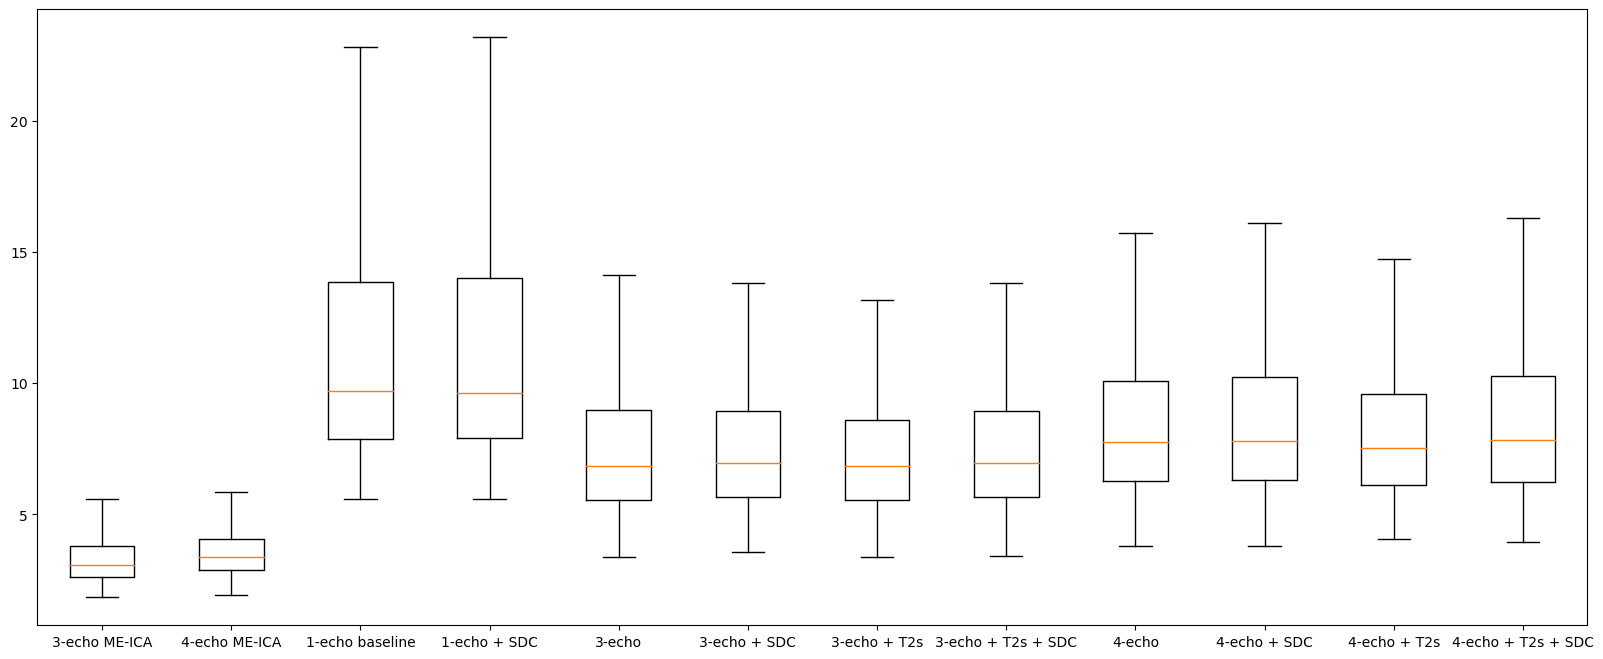

In [24]:
# Create a simple DVARS boxplot
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots(figsize=(20,8))
dvars_figure = ax.boxplot(pipeline_list, 
                          #notch=True, 
                          bootstrap=5000, 
                          showfliers=False)
ax.set_xticklabels(pipeline_names)
#plt.show(dvars_figure)
plt.savefig("dvars.png")

In [ ]:
# Convert the list of Pandas Series objects into a Pandas DataFrame object
pipeline_df = pd.concat(pipeline_list, axis=1)
pipeline_df

In [27]:
# Rename columns so that they are labelled by the pipeline names
pipeline_df.columns = pipeline_names

In [ ]:
# Visualise the updated dataframe
pipeline_df

In [30]:
# Show median DVARS for each pipeline
for i in range(pipeline_df.shape[1]):
    print('The median for ' + pipeline_df.columns[i] + ' is = ' + str(np.median(pipeline_df.iloc[:,i])) )

The median for 3-echo ME-ICA is = 3.06789
The median for 4-echo ME-ICA is = 3.39795
The median for 1-echo baseline is = 9.72028
The median for 1-echo + SDC is = 9.61166
The median for 3-echo is = 6.8628
The median for 3-echo + SDC is = 6.95338
The median for 3-echo + T2s is = 6.83042
The median for 3-echo + T2s + SDC is = 6.9607
The median for 4-echo is = 7.75452
The median for 4-echo + SDC is = 7.81463
The median for 4-echo + T2s is = 7.51995
The median for 4-echo + T2s + SDC is = 7.83426


In [ ]:
# Create a list that contains all possible pairs of pipelines WITHOUT repetitions
combo_list = list(itertools.combinations(pipeline_names, 2))
print(combo_list)
# to see how many comparisons would be made:
print(len(combo_list))

In [32]:
# Use Wilcoxon test to obtain p-values and correct them using FDR
def wilcoxon_fdr(combo_list):
    uncorrected_p_vals = []
    # For each combo
    for n in range(len(combo_list)):
        combo_cont1 = combo_list[n][0]
        combo_cont2 = combo_list[n][1]
        # Perform Wilcoxon test 
        w, p = wilcoxon(pipeline_df.loc[:, combo_cont1].dropna(), pipeline_df.loc[:, combo_cont2].dropna())
        uncorrected_p_vals.append(p)
    
    # Correct the p-values using the FDR method
    # and more specifically, one of the newer variations (https://www.jstor.org/stable/20441303?seq=1)
    corrected_p_vals_extra = multipletests(uncorrected_p_vals, alpha=0.05, method='fdr_tsbky')
    corrected_p_vals = corrected_p_vals_extra[1]
    return uncorrected_p_vals, corrected_p_vals

In [33]:
uncorrected_p_vals, corrected_p_vals = wilcoxon_fdr(combo_list)

In [34]:
print("Values lower than 0.001 =", corrected_p_vals[corrected_p_vals < 0.001])
print("Their indices are ", np.nonzero(corrected_p_vals < 0.001))

Values lower than 0.001 = [2.36514237e-242 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 4.97139610e-311 7.40616940e-304 0.00000000e+000
 3.75164701e-288 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 2.75806304e-008 1.66863211e-038 4.75984259e-009
 0.00000000e+000 0.00000000e+000 1.35944061e-283 0.00000000e+000
 1.16684266e-054 0.00000000e+000 0.00000000e+000 1.05013416e-253
 0.00000000e+000 5.44500853e-058 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 5.38535826e-262 0.00000000e+000 1.42236793e-010 1.09864672e-075

In [37]:
# > 0.001: only those at indices 21 and 46 (still significant)
print('p-value for', combo_list[21], corrected_p_vals[21])
print('p-value for', combo_list[46], corrected_p_vals[46])

p-value for ('1-echo baseline', '1-echo + SDC') 0.006303449943579408
p-value for ('3-echo + SDC', '3-echo + T2s + SDC') 0.0016776806533676872


/var/folders/m9/p56_m_mx2ts_kn07k2g983gm0000gn/T/ipykernel_16864/1172383256.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pipeline_names, rotation=45, fontsize=25)
/var/folders/m9/p56_m_mx2ts_kn07k2g983gm0000gn/T/ipykernel_16864/1172383256.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '5', '10', '15', '20'], rotation=0, fontsize=25)


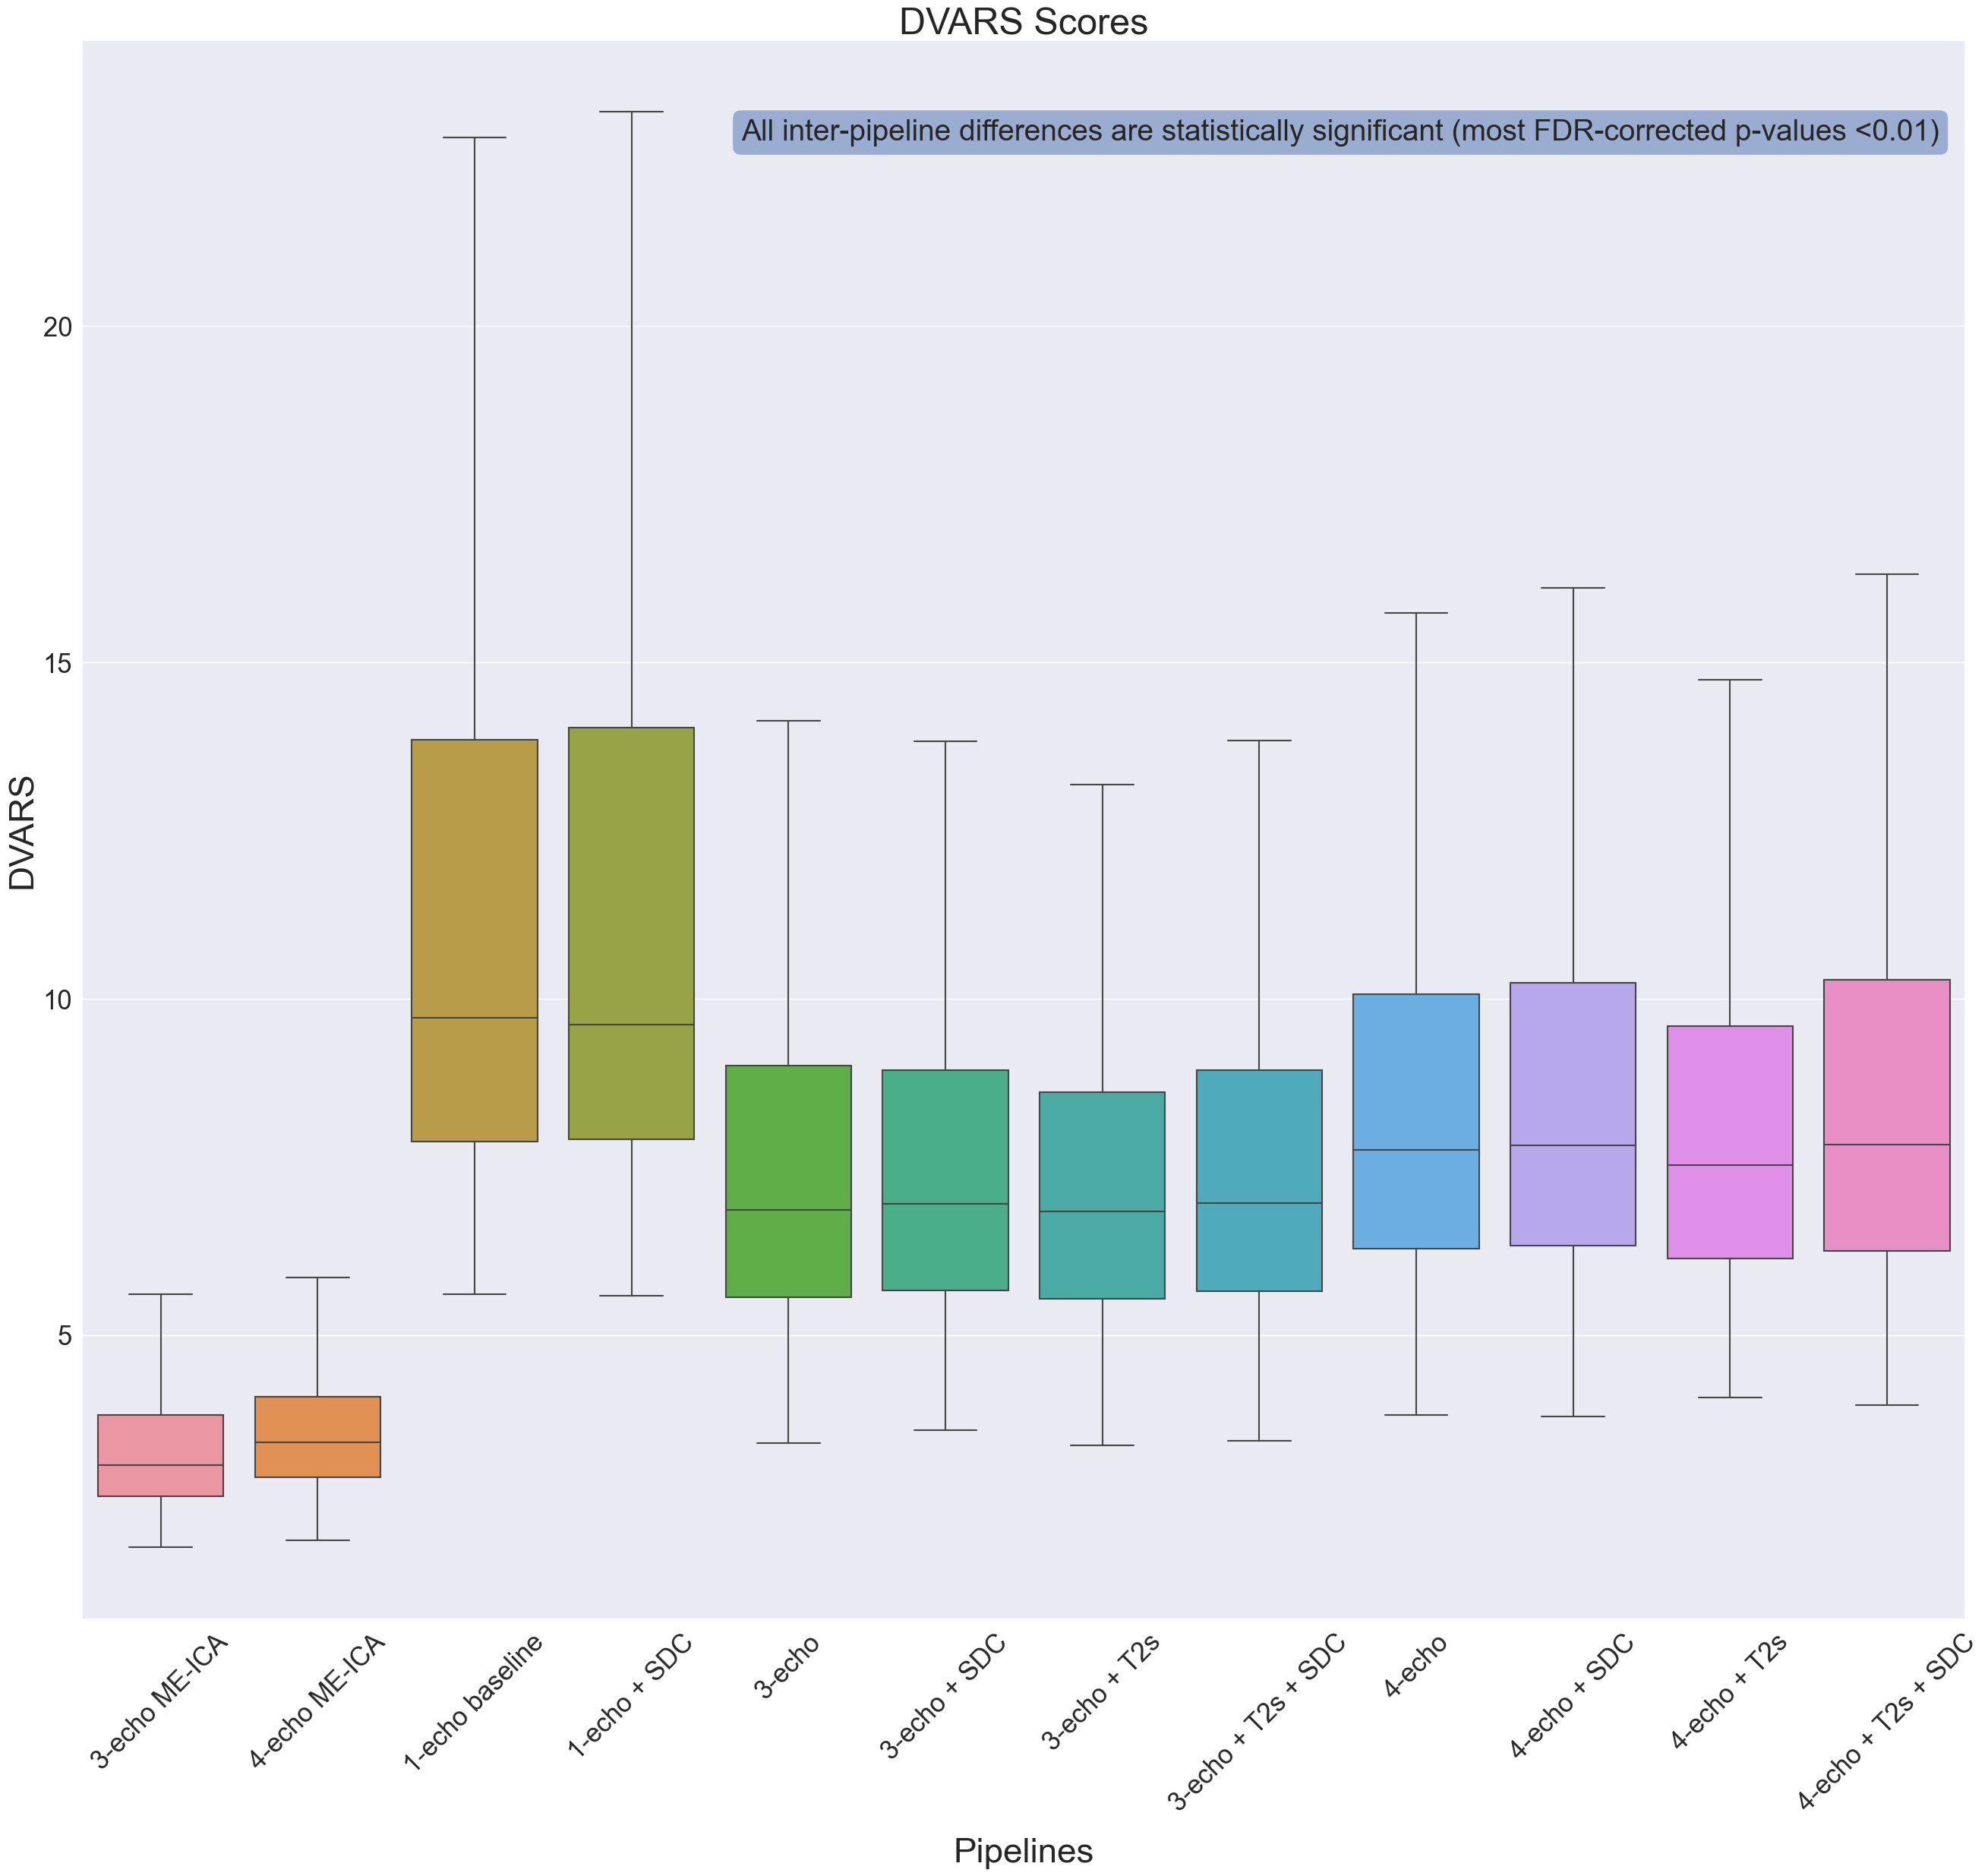

In [41]:
# Create a detailed DVARS boxplot
plt.rcParams["axes.labelsize"] = 33

# create the boxplot using seaborn instead of matplotlib
fig, ax = plt.subplots(figsize=(32,27))
sns.set(font_scale = 2)
ax.tick_params(axis='both', which='both', labelsize=15)
ax.set_xticklabels(pipeline_names, rotation=45, fontsize=25)
ax.set_yticklabels(['0', '5', '10', '15', '20'], rotation=0, fontsize=25)
ax.xaxis.labelpad = 20

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', 
             #facecolor='wheat', 
             alpha=0.5)

# place a text box in upper right in axes coords
textstr = 'All inter-pipeline differences are statistically significant (most FDR-corrected p-values <0.01)'
ax.text(0.35, 0.95, textstr, transform=ax.transAxes, fontsize=28,
        verticalalignment='top', bbox=props)

sb_ax = sns.boxplot(data=pipeline_df, #corr_matrix_list, 
                    order=pipeline_names, 
                    showfliers=False).set(
    xlabel='Pipelines', 
    ylabel='DVARS'
)


# plot with corrected p-values 

# CHANGE THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#test_results = add_stat_annotation(sb_ax, data=df_pipeline_list, order=pipeline_names,
#                                   box_pairs=[combo_list[n] for n in range(len(combo_list))],
#                                   perform_stat_test=False, pvalues=corrected_p_vals,
#                                   text_format='star',
#                                   loc='outside', verbose=2)

#plt.title('DVARS Scores')
ax.set_title('DVARS Scores',fontsize= 35) # title of plot

#plt.show()
plt.savefig("DVARS.png")